# Using RetVec to train an emotion classifier

RetVec is a state of art text tokenizer that works directly out of raw strings to create resilient models. Model trained with RetVec acheive state of art classification performance
and exhibit strong resilience to adversarial attacks as reported in our [paper](https://arxiv.org/abs/2302.09207).


RetVec speed, low , and stateless nature makes it the perfect choice to train and deploy
small and efficient on-device models. It is natively supported in TFLite via custom ops implemented in tensorflow-text for ondevice models and we provide a Javascript implementation RetVecJS that allows to deploy web models via TFJS.


This notebook demonstrates how to quickly train and use a text emotion classifier.
This classifier can then be easily exported to run in a webpage as demonstrate in 
this notebook

Let's get started

In [14]:
# installing needed dependencies
try:
    import retvec
except:
    !pip install retvec  # is retvec installed?
try:
    import datasets
except:
    !pip install datasets  # used to get the dataset

try:
    import matplotlib
except:
    !pip install matplotlib



In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from datasets import load_dataset
from matplotlib import pyplot as plt

/Users/elieb/git/retvec/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this notebook we are using the `RETVecTokenizer()` layer which perform the binarization and embedding in a single step. This is the best approach for GPU training. For TPU training,
it is more efficient to split the two steps -- see our TPU training notbook for this.


In [10]:
 # RetVec tokenizer layer.
from retvec.tf import RETVecTokenizer   

## Create dataset

We are going to use the [Go Emotion dataset](https://huggingface.co/datasets/go_emotions) to create a mulit-class emotion classifier.
https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html

In [16]:
# downloading
dataset = load_dataset('go_emotions')

In [17]:
# getting class name mapping and number of class
CLASSES = dataset['train'].features['labels'].feature.names
NUM_CLASSES = len(CLASSES)
print(f"num classes {NUM_CLASSES}")
print(CLASSES)

num classes 28
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [78]:
# preparing data
x_train = tf.constant(dataset['train']['text'], dtype=tf.string)

# the one-hot requires a little more due to the multi-class nature of the dataset.
y_train = np.zeros((len(x_train),NUM_CLASSES))
for idx, ex in enumerate(dataset['train']['labels']):
    for val in ex:
        y_train[idx][val] = 1

# test data
x_test = tf.constant(dataset['test']['text'], dtype=tf.string)
y_test = np.zeros((len(x_test),NUM_CLASSES))
for idx, ex in enumerate(dataset['test']['labels']):
    for val in ex:
        y_test[idx][val] = 1


## Model

A key strength of RetVec is that input to the model are 
the raw datasets string with no pre-processing which greatly simplify the training and inference process. In particular for on-device models. 

Notes:
- Using strings directly as input requires to use a shape of `(1,)` and specify the type `tf.string`

- We are using `RetVecTokenizer()` in its default configuration which is to truncate at `128` words and use a small pretained model for the embedding. You can experiment with shorter or longer length by changing the `sequence_length`
parameter.

In [128]:


# Using strings directely requires to put a shape of (1, ) and a dtype: tf.string
inputs = layers.Input(shape=(1, ), name="token", dtype=tf.string)

# we are using RetVec with it's default settings
x = RETVecTokenizer(model='retvec-v1')(inputs)

# Adding a batch norm after RetVec usually help with the convergence
x = layers.BatchNormalization()(x)

# standard three LSTM layers
x = layers.SpatialDropout1D(0.1)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
  

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token (InputLayer)          [(None, 1)]               0         
                                                                 
 ret_vec_tokenizer_14 (RETV  (None, 128, 256)          230144    
 ecTokenizer)                                                    
                                                                 
 batch_normalization_14 (Ba  (None, 128, 256)          1024      
 tchNormalization)                                               
                                                                 
 spatial_dropout1d_16 (Spat  (None, 128, 256)          0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_26 (Bidirect  (None, 128, 128)          164352    
 ional)                                                   

In [129]:
batch_size = 128
epochs = 50
model.compile('adam', 'binary_crossentropy', ['acc'])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test))

Epoch 1/50


2023-08-03 15:19:13.127544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:19:14.165134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:19:14.184875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:19:14.439446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:19:14.460276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:19:14.691597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:19:14.709305: I tensorflow/core/grappler/optimizers/cust

340/340 [==============================] - ETA: 0s - loss: 0.1727 - acc: 0.2734

2023-08-03 15:20:08.448031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:20:08.890213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:20:08.903641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:20:09.091102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:20:09.103586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:20:09.291403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:20:09.304346: I tensorflow/core/grappler/optimizers/cust

340/340 [==============================] - 67s 169ms/step - loss: 0.1727 - acc: 0.2734 - val_loss: 0.1479 - val_acc: 0.2959
Epoch 2/50
340/340 [==============================] - 49s 143ms/step - loss: 0.1490 - acc: 0.2954 - val_loss: 0.1464 - val_acc: 0.2959
Epoch 3/50
340/340 [==============================] - 49s 145ms/step - loss: 0.1455 - acc: 0.3104 - val_loss: 0.1394 - val_acc: 0.3455
Epoch 4/50
340/340 [==============================] - 48s 142ms/step - loss: 0.1381 - acc: 0.3532 - val_loss: 0.1330 - val_acc: 0.3650
Epoch 5/50
340/340 [==============================] - 49s 144ms/step - loss: 0.1339 - acc: 0.3682 - val_loss: 0.1295 - val_acc: 0.3932
Epoch 6/50
340/340 [==============================] - 49s 143ms/step - loss: 0.1309 - acc: 0.3921 - val_loss: 0.1261 - val_acc: 0.4166
Epoch 7/50
340/340 [==============================] - 49s 145ms/step - loss: 0.1279 - acc: 0.4106 - val_loss: 0.1238 - val_acc: 0.4229
Epoch 8/50
340/340 [==============================] - 48s 142ms/st

340/340 [==============================] - 69s 176ms/step - loss: 0.1677 - acc: 0.2777 - val_loss: 0.1479 - val_acc: 0.2959
Epoch 2/30
340/340 [==============================] - 51s 151ms/step - loss: 0.1492 - acc: 0.2954 - val_loss: 0.1471 - val_acc: 0.2959
Epoch 3/30
340/340 [==============================] - 52s 154ms/step - loss: 0.1453 - acc: 0.3122 - val_loss: 0.1368 - val_acc: 0.3586
Epoch 4/30
340/340 [==============================] - 56s 164ms/step - loss: 0.1360 - acc: 0.3648 - val_loss: 0.1306 - val_acc: 0.3833
Epoch 5/30
340/340 [==============================] - 51s 150ms/step - loss: 0.1301 - acc: 0.3988 - val_loss: 0.1246 - val_acc: 0.4150

In [130]:
# saving the model so we can use it on the web
model.save('demo_models/emotions.keras')  # new saving format requires .keras

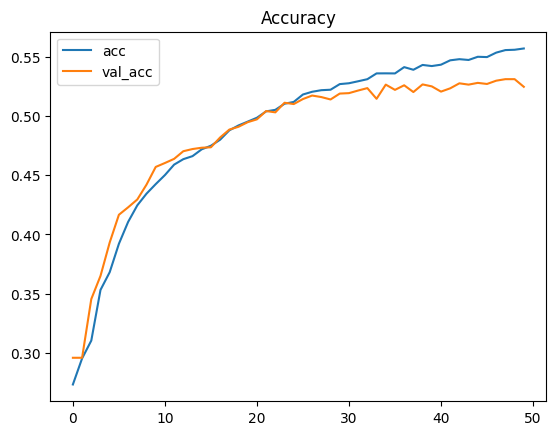

In [131]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title(f'Accuracy')
plt.show()

## model testing
let's test how well the model perform

In [13]:
# reload
model = tf.keras.models.load_model('demo_models/emotions.keras', compile=False)

In [25]:
def predict_emotions(txt, threshold=0.5):
    # recall it is multi-class so we need to get all prediction above a threshold (0.5)
    preds = model(tf.constant([txt]))[0]
    out = 0
    for i in range(NUM_CLASSES):
        if preds[i] > threshold:
            emotion_name = CLASSES[i]
            emotion_prob = round(float(preds[i]) * 100, 1)
            print(f"{emotion_name} ({emotion_prob})%")
            out += 1
    if not out:
        print("neutral") 
            

In [29]:
txt = "I enjoy having a good icecream"
predict_emotions(txt)

joy (91.6)%
